<a href="https://colab.research.google.com/github/jnramirezg/medio_continuo/blob/main/codigo/29-modelo_viga_voladizo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Análisis y diseño esquemático de viga en voladizo

|Quién | Fecha | Qué hizo |
| ---  | ---   | ---      |
|Juan Nicolás Ramírez, <jnramirezg@unal.edu.co> | 2023-02-21 | Creando código|

En este programa analizamos con variables simbólicas la siguiente viga en voladizo con carga distribuida, después reemplazamos con valores numéricos para calcular mediante la teoría de Euler-Bernoulli las funciones de fuerza cortante, momento flector, ángulo de giro y deflexión (desplazamiento vertical). Finalmente se grafican $\sigma_x$, $\tau_{xy}$, $\sigma_1$, $\sigma_2$ y se presenta un esquema de diseño convencional.

![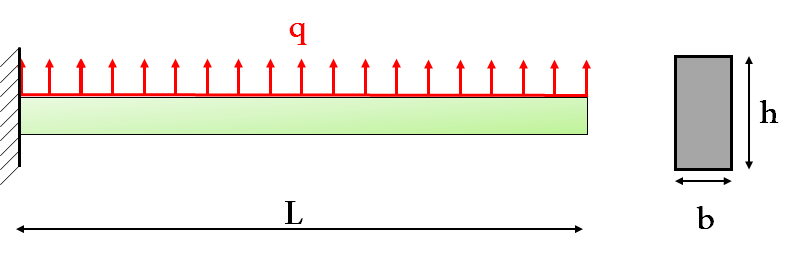](attachment:imagen.png)
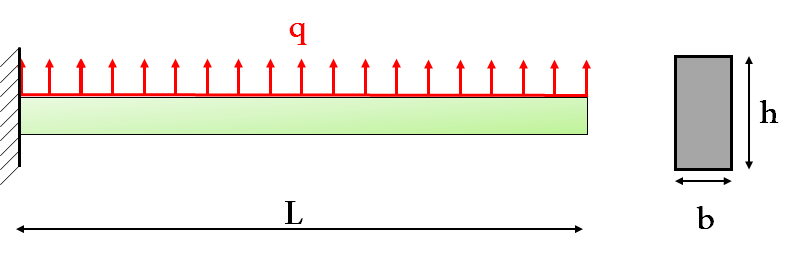

Importamos las librerías necesarias:

In [1]:
from sympy import *
from numpy import *
from matplotlib.pyplot import *

In [2]:
L, q, EI = symbols("L, q, EI")          # Propiedades de la viga.
x = symbols("x")                            # Variable de posición.
c1, c2, c3, c4 = symbols("c1, c2, c3, c4")  # Constantes de integración.

Usamos las siguientes ecuaciones de la viga de Euler-Bernoulli de la sección 9.9 del ````main.pdf````:

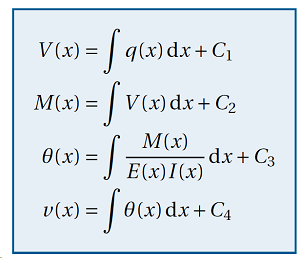

In [3]:
V =  integrate(q, x) + c1         # Fuerza cortante.
M =  integrate(V, x) + c2         # Momento flector.
t = (integrate(M, x) + c3)/(EI)   # Ángulo de giro.
v =  integrate(t, x) + c4         # Deflexión (desplazamiento vertical).

Consideramos las siguientes condiciones de frontera de la sección 9.7 del ````main.pdf````:

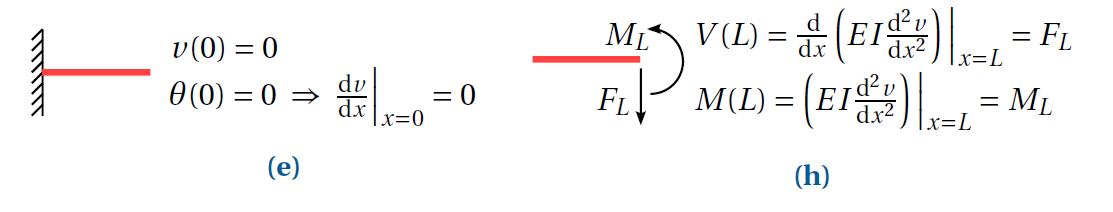

In [4]:
e1 = v.subs(x, 0) - 0  # v(0)=0
e2 = t.subs(x, 0) - 0  # t(0)=0
e3 = V.subs(x, L) - 0  # V(L)=0 (No hay fuerza ni momento aplicados).
e4 = M.subs(x, L) - 0  # M(L)=0 (No hay fuerza ni momento aplicados).

Calculamos las constantes de integración con las ecuaciones aportadas por las condiciones de frontera:

In [5]:
c = solve([e1, e2, e3, e4],[c1, c2, c3, c4])

In [6]:
c

{c4: 0, c3: 0, c1: -L*q, c2: L**2*q/2}

Substituimos las constantes calculadas:

In [7]:
V = V.subs(c)
M = M.subs(c)
t = t.subs(c)
v = v.subs(c)

In [8]:
v

L**2*q*x**2/(4*EI) - L*q*x**3/(6*EI) + q*x**4/(24*EI)

Finalmente, obtenemos las siguientes funciones:
$$V(x)=   qx -  L q $$

$$M(x)=  \frac{1}{2}qx^{2}-qLx +  \frac{1}{2}qL^{2}$$

$$EI\theta(x)= \frac{1}{6} qx^{3}- \frac{1}{2}qLx^{2}  +\frac{1}{2}qL^{2}x $$

$$EIv(x)= \frac{1}{24} qx^{4}- \frac{1}{6}qLx^{3}  +\frac{1}{4}qL^{2}x^2 $$

## Deflexión máxima

La deflexión máxima está en la posición $x=L$

In [9]:
v.subs(x,L)

L**4*q/(8*EI)

## Ejemplo numérico

Supongamos que la viga tiene las siguientes propiedades:

**Nota:** En algunos casos ponemos el subindice ````i```` para diferenciar de las variables simbólicas.
### Geométricas
* $b = 0.40m$ (Ancho de la viga)
* $h = 0.70m$ (Altura de la viga)
* $L = 10m$ (Longitud de viga)

In [10]:
b  = 0.4
h  = 0.7
Li = 10
Ii = b*h**3/12  # [m4] Momento de inercia.

### Del material

$f'c=21MPa$ (resistencia a compresión del concreto)

$E = 4700 \sqrt{f'c}$ en MPa según la sección C.8.5 de la NSR-10

In [11]:
fpc = 21              # [MPa]
Ei = 4700*(fpc)**0.5  # [MPa]
Ei = Ei*1000          # [kPa]

### Cargas

In [12]:
qi = -30

Substituimos los valores simbólicos con los valores numéricos del ejemplo:

In [13]:
V = V.subs([(L,Li), (q,qi)])
M = M.subs([(L,Li), (q,qi)])
t = t.subs([(L,Li), (q,qi), (EI,Ei*Ii)])
v = v.subs([(L,Li), (q,qi), (EI,Ei*Ii)])

Usamos la función ````sympy.lambdify```` para convertir las expresiones simbólicas en funciones evaluables en varios puntos numéricos:

In [14]:
V = lambdify(x, V, "numpy")
M = lambdify(x, M, "numpy")
t = lambdify(x, t, "numpy")
v = lambdify(x, v, "numpy")

Definimos una malla de evaluación en el plano xy, en este caso de tamaño (20,10)
:

In [15]:
x, y = meshgrid(linspace(   0,  Li, 20),  # Dirección x.
                linspace(-h/2, h/2, 10))  # Dirección y, va de -h/2 hasta h/2 porque el eje neutro está en y=0.

In [16]:
sx = -M(x)*y/Ii                  # [kN/m2]     
txy = V(x)*(y**2-h**2/4)/(2*Ii)  # [kN/m2]
sy = qi*(2*y+h)/(2*b*h)          # [kN/m2]

In [17]:
tmax = sqrt(((sx - sy)/2)**2 + txy**2)
s1 = (sx+sy)/2 + tmax
s2 = (sx+sy)/2 - tmax
t1 = arctan2(2*txy, sx-sy)/2  
t2 = arctan2(-2*txy, -(sx-sy))/2

Definimos una función para graficar cortantes, momentos, ángulos de giro y deflexiones:

In [18]:
def grafico_funcion_viga(x, f, titulo):
    figure(figsize=(20, 4))
    plot(x, f, 'r')
    plot([0, max(x)], [0, 0], 'k')
    xlabel("Posición [m]")
    ylabel(titulo)
    xlim(0, max(x))
    show()

Creamos una función que permita graficar los esfuerzos y las deformaciones:

In [19]:
def dibujar_esf_def(titulo, f, x, y, angulo=None):
    curvas = linspace(f.min(), f.max(), 20)  # Definimos 20 curvas de nivel. 
    figure(figsize=(20, 4))
    im = pcolormesh(x, y, f, vmin=f.min(), vmax=f.max(), shading='gouraud', cmap='jet_r')
    # Para los esfuerzos principales se grafican las líneas que indiquen las
    # direcciones de los esfuerzos en cada nodo de la malla.
    if angulo is not None:
        escala_ang = abs(f)**(1/3)  # Escalamos la magnitud del ángulo.
        if type(angulo) is ndarray:
            angulo = [angulo]
        for i in angulo:
            # Dibujamos las direcciones.
            quiver(x, y, escala_ang*cos(i), escala_ang*sin(i), headwidth=0, headlength=0, headaxislength=0, pivot="middle")  
    # Se grafica la función con colores.
    contour(x, y, f, levels=curvas, colors='k', linestyles='-', linewidths=0.7)
    colorbar(im, aspect=5)       # Se crea una barra de color lateral.
    ylabel(titulo, fontsize=18)  # Título.
    xlim(x.min(), x.max())       # Límites en x del gráfico.
    ylim(y.min(), y.max())       # Límites en y del gráfico.
    show()

# Gráficos:

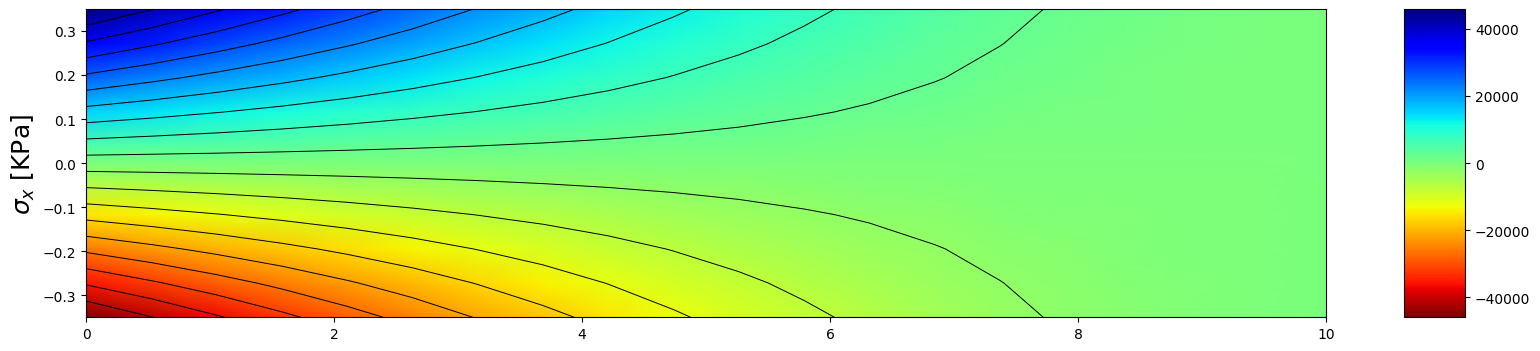

In [20]:
dibujar_esf_def(r"$\sigma_x$ [KPa]", sx, x, y)

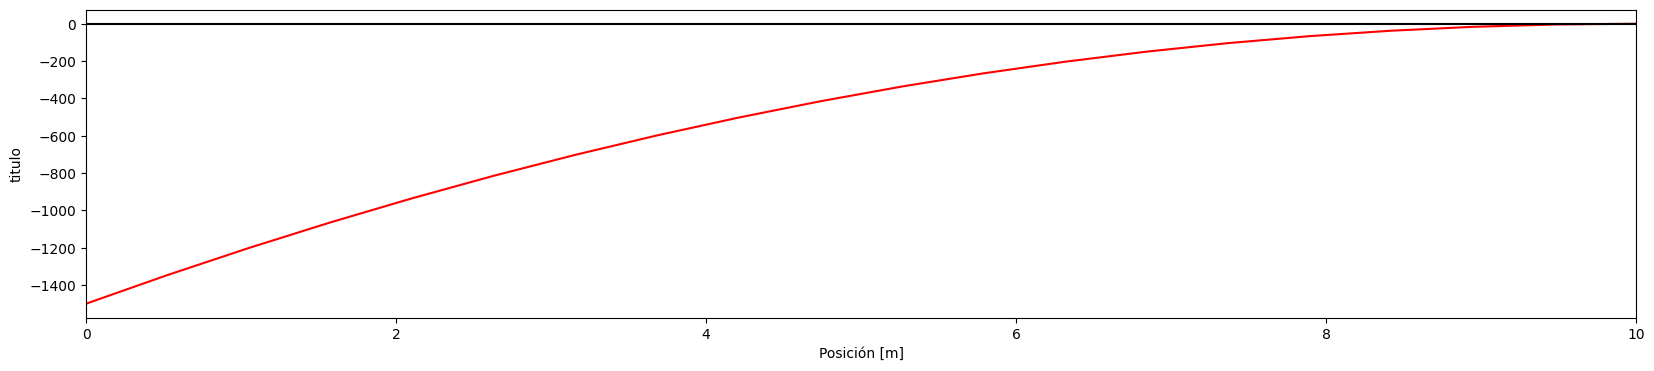

In [21]:
grafico_funcion_viga(x[0], M(x[0]), "titulo")

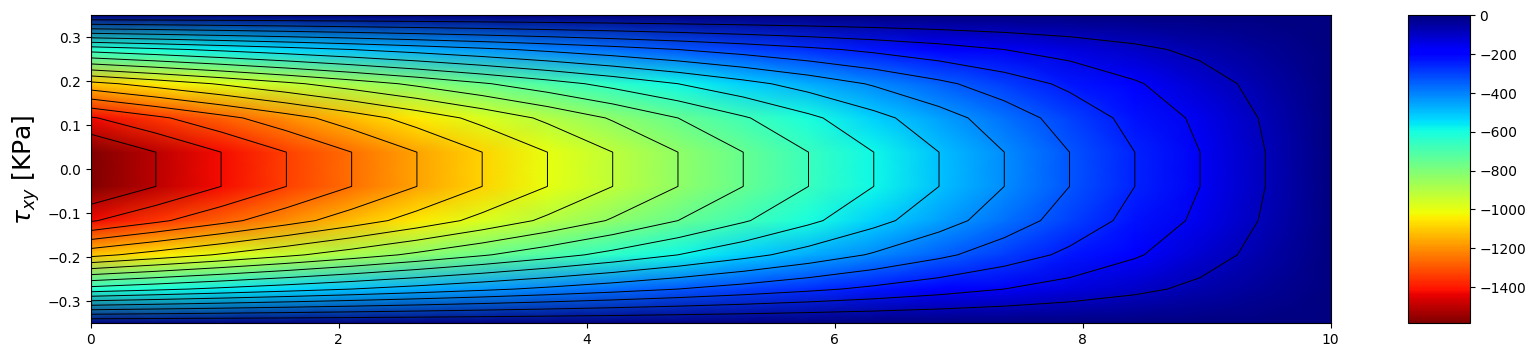

In [22]:
dibujar_esf_def(r"$\tau_{xy}$ [KPa]", txy, x, y)

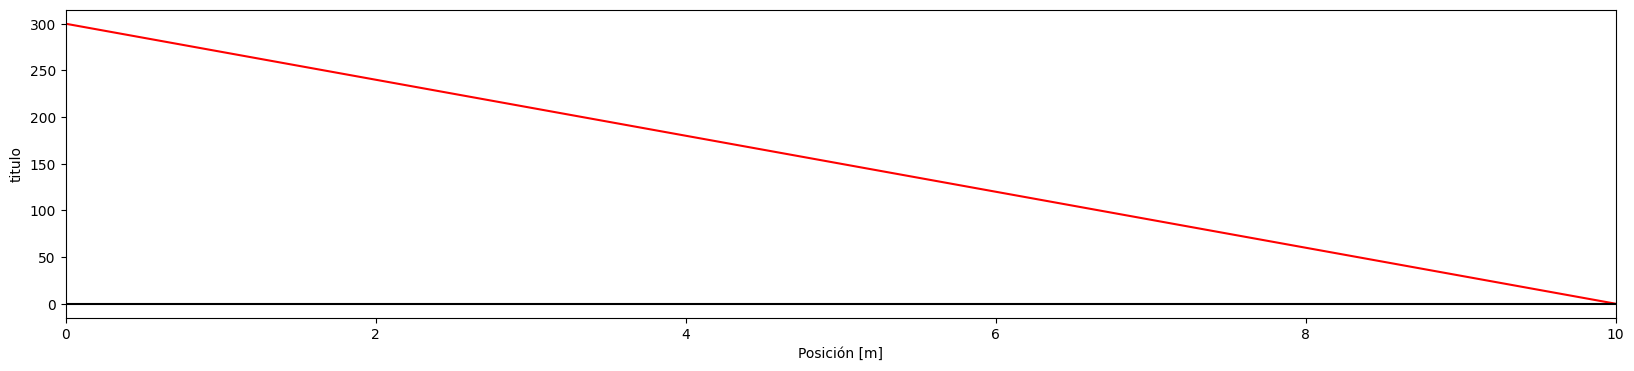

In [23]:
grafico_funcion_viga(x[0], V(x[0]), "titulo")

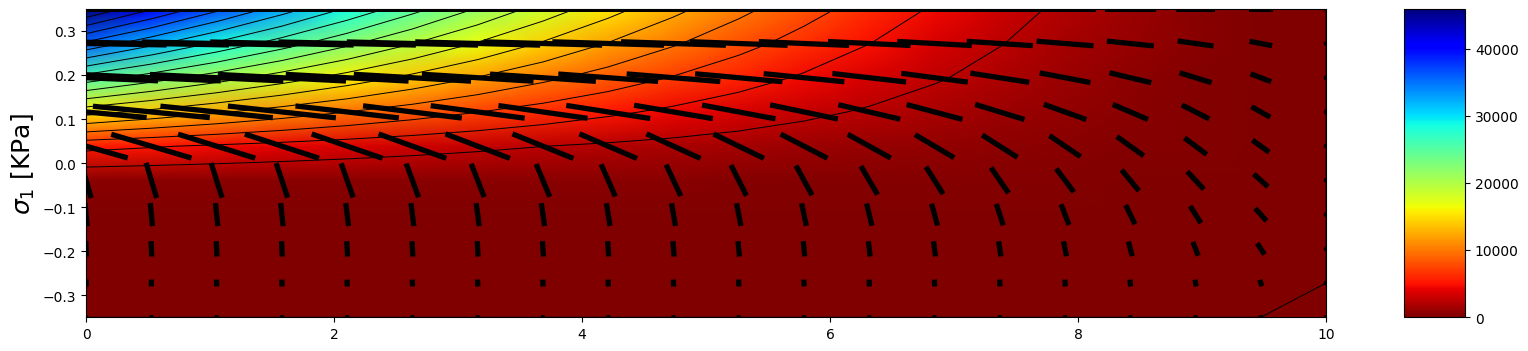

In [24]:
dibujar_esf_def(r"$\sigma_1$ [KPa]", s1, x, y, t1)

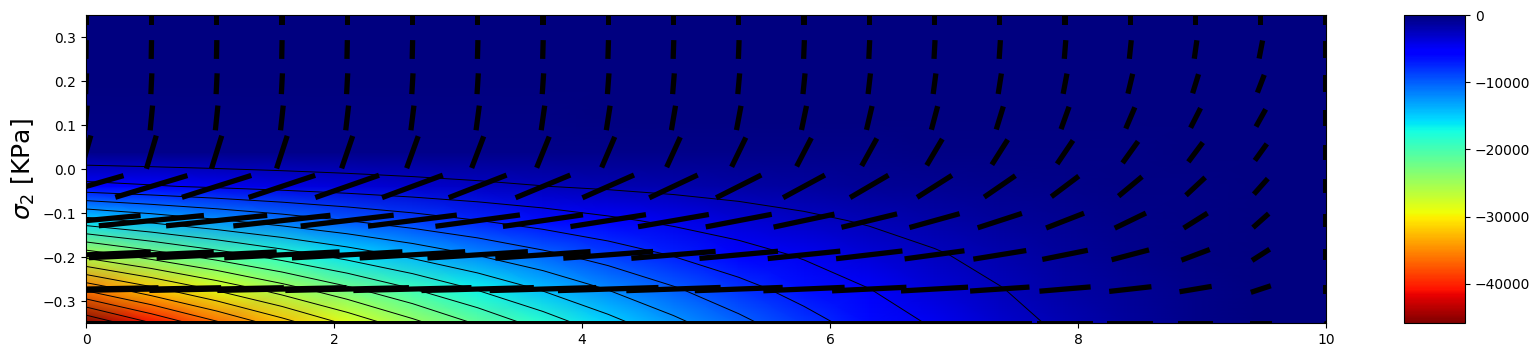

In [25]:
dibujar_esf_def(r"$\sigma_2$ [KPa]", s2, x, y, t2)